#### Example running SpaFHy with jupyter notebook

In [1]:
from model_driver import driver
from iotools import read_results
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os

#os.chdir(r'/projappl/project_2000908/nousu/SpaFHy_v2.0')
os.chdir(r'/Users/jpnousu/SpaFHy_v2.0')

catchment = 'krycklan'

# example of calling driver, reading results
outputfile = driver(catchment, create_ncf=True, create_spinup=False, folder='/Users/jpnousu/SpaFHy_RUNS/krycklan')
results = xr.open_dataset(outputfile)

%load_ext autoreload
%autoreload 2

*** Defined root soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used root soil IDs: {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0} ***
*** Defined organic soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used organic soil IDs: {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0} ***
*** Defined deep soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used soil IDs: {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0}
*** State variables assigned from parameters.py ***
*** Simulation forced with: /Users/jpnousu/SpaFHy_RUNS/krycklan/forcing/FORCING.csv
*** Running model ***
*** 2D run
*** Bucket organic layer drains according to Campbell 1985
Running timestep:  1
Timestep: 1 , iterations: 9 , conv1: 2.3874235921539366e-12 , H[max_index]: -0.20000000000206342
Running timestep:  2
Timestep: 2 , iterations: 9 , conv1: 2.5863755581667647e-12 , H[max_index]: -0.2000000000030866
Running timestep:  3
Timestep: 3 , iterations: 9 , conv1: 3.808509063674137e-12 , H[max_index]: -0.199999

/Users/jpnousu/SpaFHy_v2.0/bucketgrid.py:272: RuntimeWarning: invalid value encountered in power
  Psi = -1 / self.alpha_root*(s**(1.0 / m) - 1.0)**(1.0 / n)  # alpha defines the unit (kPa)


Timestep: 9 , iterations: 7 , conv1: 1.3301360013429075e-11 , H[max_index]: 0.00469170610969627
Running timestep:  10
Timestep: 10 , iterations: 7 , conv1: 1.610374056326691e-10 , H[max_index]: 0.003168278261995283
Running timestep:  11
Timestep: 11 , iterations: 6 , conv1: 1.2493899248511298e-09 , H[max_index]: -0.16182634327597611
Running timestep:  12
Timestep: 12 , iterations: 7 , conv1: 3.6567371353157796e-10 , H[max_index]: 0.0005861996714884299
Running timestep:  13
Timestep: 13 , iterations: 6 , conv1: 0.0005369134472914538 , H[max_index]: 0.002635030705249619
Running timestep:  14
Timestep: 14 , iterations: 4 , conv1: 0.0009423539910642376 , H[max_index]: -0.025693988363826747
Running timestep:  15
Timestep: 15 , iterations: 6 , conv1: 0.0001344153194224873 , H[max_index]: 0.00274041716951956
Running timestep:  16
Timestep: 16 , iterations: 5 , conv1: 0.0008913678010173953 , H[max_index]: 0.001686983325470237
Running timestep:  17
Timestep: 17 , iterations: 4 , conv1: 0.000667

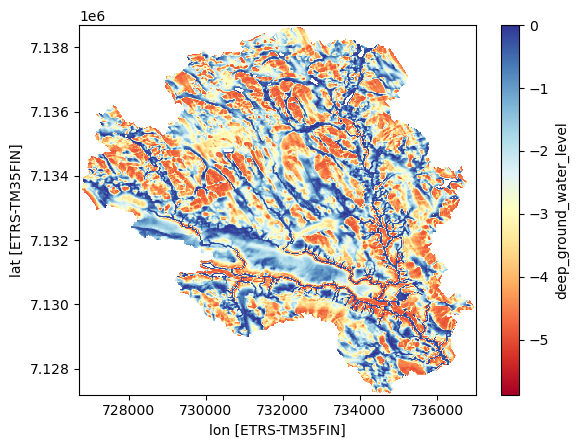

In [21]:
#results['deep_ground_water_level'][-1].plot(cmap='RdYlBu')
#results['deep_lateral_netflow'].mean(dim='time').plot(cmap='RdYlBu', vmin=-2, vmax=2)
results['deep_ground_water_level'].mean(dim='time').plot(cmap='RdYlBu')
#results['deep_lateral_netflow'].mean(dim='time')[200:400,100:300].plot(cmap='RdYlBu', vmin=-50, vmax=50)
#results['deep_ground_water_level'].mean(dim=['lat', 'lon']).plot()

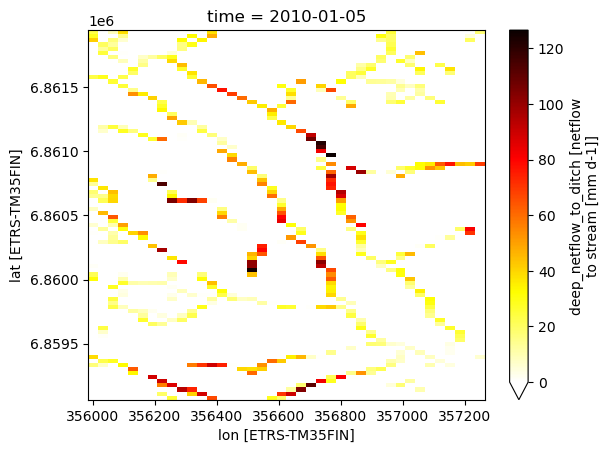

In [3]:
#results['deep_netflow_to_ditch'][-1, 70:100, 270:300].plot(vmin=0, cmap='hot_r')
results['deep_netflow_to_ditch'][-1, 95:185, 250:290].plot(vmin=0, cmap='hot_r')

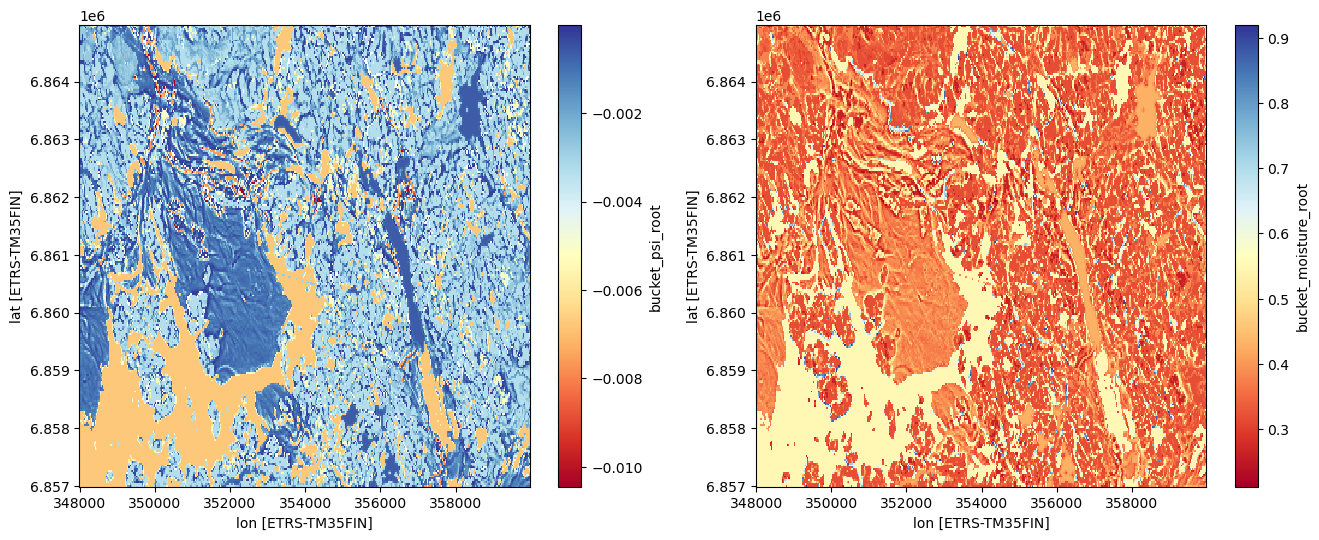

In [4]:
date = '2020-08-01'
plt.figure(figsize=(16,6))
ax=plt.subplot(1,2,1)
#results['bucket_psi_root'].sel(time=date).plot(cmap='coolwarm_r')
results['bucket_psi_root'].mean(dim=['time']).plot(cmap='RdYlBu')
plt.subplot(1,2,2, sharex=ax, sharey=ax)
#results['bucket_moisture_root'].sel(time=date)[20:-60,70:-100].plot(cmap='coolwarm_r')
results['bucket_moisture_root'].mean(dim=['time']).plot(cmap='RdYlBu')
#results['bucket_moisture_root'].sel(time=date).plot(cmap='coolwarm_r')
#plt.subplot(1,2,3, sharex=ax, sharey=ax)
#plt.subplot(2,2,4, sharex=ax, sharey=ax)
#results['bucket_moisture_top'].sel(time=date)[20:-60,70:-100].plot(cmap='coolwarm_r')

In [ ]:
import xarray as xr
file = r'/scratch/project_2000908/nousu/SpaFHy_RESULTS/testcase_input_202403121454.nc'
results = xr.open_dataset(file)

In [ ]:
firedata = results[['forcing_wind_speed', 'forcing_air_temperature', 'forcing_relative_humidity', 
                    'bucket_psi_root']].copy()
results.close()

In [ ]:
# subset by month
firedatass = firedata.sel(time=firedata.time.dt.month.isin([5, 6, 7, 8, 9])).copy()
# subset by snow
#firedatass = firedata.sel(time=(results['canopy_snow_water_equivalent'].max(dim=['lat','lon']) == 0)).copy()

In [ ]:
firedatass['forcing_wind_speed'][:].plot()

In [ ]:
fp = r'/scratch/project_2000908/nousu/SpaFHy_RESULTS/spafhy_for_fire_3_24.nc'
firedatass.to_netcdf(fp, 'w')
firedatass.close()